# SE3 implementation

In [1]:
import os
import time
from copy import copy
from pathlib import Path
from pdb import set_trace

import matplotlib.pyplot as plt
import numpy as np
import psutil
import src.se3.visualization as viz
import torch
import torch.nn as nn
from se3_transformer_pytorch.irr_repr import rot

from src.ri_distances.SGW.risgw import RISGW_loss
from src.se3.torch_funcs import MachineScaleChecker, visualize_prediction, get_model
from src.se3.visualization import viz_point_cloud
from src.ri_distances.pnt_cloud_generation import get_src_scaled_spirals, get_src_shifted_spirals, get_spiral,center

import wandb

plt.style.use('ggplot')
model_path = Path("/content/drive/MyDrive/se3_transformer.pt")
torch.set_default_dtype(torch.float32) # works best in float64


You can visualize the type of point cloud you overfit in this cell

## Experiment 1

We define the various parameter for the SE3 training

In [11]:
transformer = get_model()
epochs = 15
criterion = torch.nn.MSELoss()
batch_size = 4
lr = 0.01
optimizer = torch.optim.Adam(transformer.parameters(),lr=lr)
#optimizer = torch.optim.SGD(transformer.parameters(), lr=0.1, momentum=0.9)

center_input = False
center_output = False
center_target = False

batch_f = get_src_scaled_spirals
batch_f_kwargs = {'center_input':center_input,'center_target':center_target}
use_wandb = True

Loading fresh model


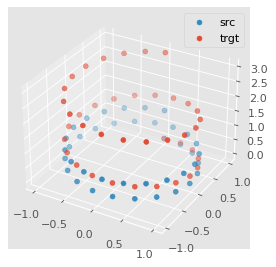

In [12]:
points, target_points = batch_f(**batch_f_kwargs)
viz_point_cloud([(points,'src'),(target_points,'trgt')])#,[cent_points,cent_target_points])

In [25]:
if use_wandb:
    wrun = wandb.init("se3_runs")
    config = wandb.config
    config.criterion = criterion
    config.optimizer = optimizer
    config.lr = lr
    config.batch_f = batch_f
    config.batch_f_kwargs = batch_f_kwargs
    config.center_input = center_input
    config.center_target = center_target
    config.center_output = center_output
    wandb.watch(transformer)
for epoch in range(epochs):
    train_args = {"model":transformer,
                "use_wandb":use_wandb,
                "optimizer":optimizer,
                "epoch":epoch,
                "criterion":criterion,
                "batch_size":batch_size,
                "scheduler":scheduler,
                "device":device,
                "batch_f":batch_f,
                "batch_f_kwargs":batch_f_kwargs,
                "center_output":centering}
    loss = train_one_epoch(**train_args)

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
Retry attempt failed:
Traceback (most recent call last):
  File "/home/ymentha/Documents/Cours/graph_project/se3_project/env/lib/python3.6/site-packages/urllib3/connection.py", line 170, in _new_conn
    (self._dns_host, self.port), self.timeout, **extra_kw
  File "/home/ymentha/Documents/Cours/graph_project/se3_project/env/lib/python3.6/site-packages/urllib3/util/connection.py", line 96, in create_connection
    raise err
  File "/home/ymentha/Documents/Cours/graph_project/se3_project/env/lib/python3.6/site-packages/urllib3/util/connection.py", line 86, in create_connection
    sock.connect(sa)
ConnectionRefusedError: [Errno 111] Connection refused

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/ymentha/Documents/Cours/graph_project/se3_project/env/lib/python3.6/site-packages/

Problem at: <ipython-input-25-85eb27508210> 2 <module>


KeyboardInterrupt: 

## Visualize results

In [129]:
fig = visualize_prediction(transformer, batch_f, batch_f_kwargs, centering)
wandb.log({"chart": wandb.Image(fig)})
fig

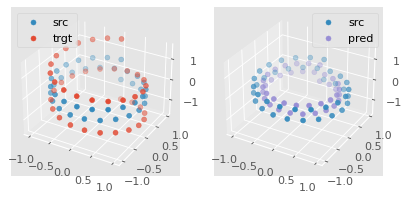

In [130]:
wrun.finish()

In [28]:
dist_pred_target = torch.nn.MSELoss()(predicted_points_tens,target_points_tens_raw)
dist_centtarg_target = torch.nn.MSELoss()(target_points_tens,target_points_tens_raw)
print(dist_pred_target)
print(dist_centtarg_target)

tensor(0.8670, grad_fn=<MseLossBackward>)
tensor(0.7502)


## Is the output systematically centered?

In [35]:
N = 25
scale = 1000
shift = 500
rand_points_tens = torch.rand(1,N,3) * scale # we scale the noise
rand_points_tens += torch.tensor([shift,shift,shift]) # and shift the point cloud
predicted_deltas_tens = predict(transformer,rand_points_tens)
print(f"Input barycenter:{rand_points_tens.mean(axis=1)}")
print(f"Output barycenter:{predicted_deltas_tens.mean(axis=1)}")

Input barycenter:tensor([[1008.4020, 1085.2714,  978.3622]])
Output barycenter:tensor([[ 6.5305e-08, -5.3242e-08, -2.1842e-08]], grad_fn=<MeanBackward1>)
